In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter('ignore')

In [2]:
train_data = pd.read_csv('datasets/titanic_train.csv')
test_data = pd.read_csv('datasets/titanic_test.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

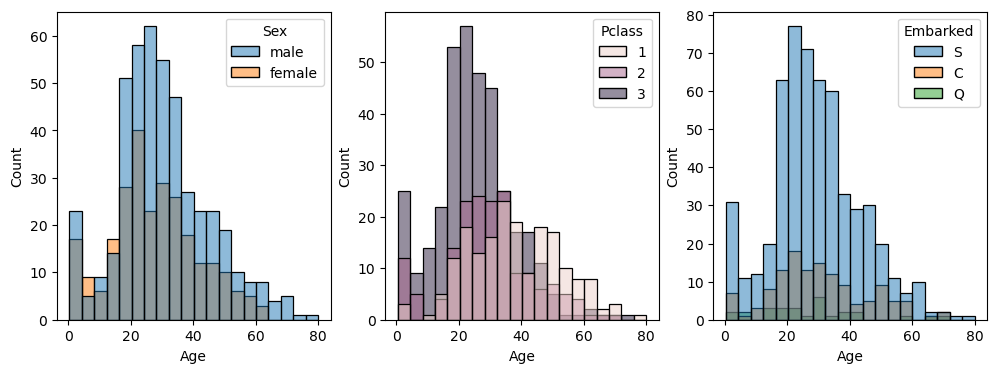

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for col, ax in zip(['Sex', 'Pclass', 'Embarked'], axes.flatten()):
    sns.histplot(train_data, x='Age', hue=col, ax=ax)

In [6]:
delete_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']

def guess_age(row, averages):
    if not np.isnan(row['Age']):
        return row['Age']
    else:
        return averages[row['Pclass']]
        
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.avg_age = None

    def fit(self, X, y=None):
        self.avg_age = X.groupby('Pclass')['Age'].mean()
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Age'] = X.apply(guess_age, axis=1, args=(self.avg_age,))
        return X

In [7]:
X = train_data.drop(columns='Survived')
y = train_data['Survived']


preprocessor = ColumnTransformer(
    transformers = [
        ('categorical', pp.OneHotEncoder(drop='first', sparse_output=False),
            make_column_selector(dtype_include = object)),
        ('numerical', pp.PowerTransformer(), make_column_selector(dtype_include = np.number))
    ])

model = Pipeline(
    steps = [
        ("delete columns", FunctionTransformer(lambda x: x.drop(delete_features, axis=1))),
        ("impute age", AgeImputer()),
        ("log", ColumnTransformer(
            transformers = [
                ("log fare", FunctionTransformer(lambda x: np.log1p(x)), ['Fare'])
            ])),
        ("imputing", SimpleImputer(strategy='most_frequent').set_output(transform='pandas')),
        ("preprocessor", preprocessor),
        ("KNN model", KNeighborsClassifier())
    ]
)

model

Pipeline(steps=[('delete columns',
                 FunctionTransformer(func=<function <lambda> at 0x00000211FD84FCE0>)),
                ('impute age', AgeImputer()),
                ('log',
                 ColumnTransformer(transformers=[('log fare',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000211FDD30040>),
                                                  ['Fare'])])),
                ('imputing', SimpleImputer(strategy='most_frequent')),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211FD6C9C10>),
                                                 ('numerical',
                                                  PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211FD790B90>)])),
                ('KNN model', KNeighborsClassifier())])

In [8]:
cv_result = cross_val_score(model, X, y, scoring='accuracy', cv=5, verbose=5)
cv_result

[CV] END ................................ score: (test=0.637) total time=   0.0s
[CV] END ................................ score: (test=0.573) total time=   0.0s
[CV] END ................................ score: (test=0.685) total time=   0.0s
[CV] END ................................ score: (test=0.708) total time=   0.0s
[CV] END ................................ score: (test=0.635) total time=   0.0s


array([0.63687151, 0.57303371, 0.68539326, 0.70786517, 0.63483146])

In [9]:
model.fit(X, y)
prediction = model.predict(test_data)
print(prediction)

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0
 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0
 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0
 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0
 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1
 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0
 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0
 1 0 1 1 1 0 0 1 0 0 1]


In [10]:
parameters = {'KNN model__n_neighbors': range(3, 15, 2)}
search = GridSearchCV(model, parameters, scoring='accuracy', cv=5, verbose=5)
search.fit(X, y)
search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........KNN model__n_neighbors=3;, score=0.631 total time=   0.0s
[CV 2/5] END ..........KNN model__n_neighbors=3;, score=0.584 total time=   0.0s
[CV 3/5] END ..........KNN model__n_neighbors=3;, score=0.719 total time=   0.0s
[CV 4/5] END ..........KNN model__n_neighbors=3;, score=0.702 total time=   0.0s
[CV 5/5] END ..........KNN model__n_neighbors=3;, score=0.646 total time=   0.0s
[CV 1/5] END ..........KNN model__n_neighbors=5;, score=0.637 total time=   0.0s
[CV 2/5] END ..........KNN model__n_neighbors=5;, score=0.573 total time=   0.0s
[CV 3/5] END ..........KNN model__n_neighbors=5;, score=0.685 total time=   0.0s
[CV 4/5] END ..........KNN model__n_neighbors=5;, score=0.708 total time=   0.0s
[CV 5/5] END ..........KNN model__n_neighbors=5;, score=0.635 total time=   0.0s
[CV 1/5] END ..........KNN model__n_neighbors=7;, score=0.631 total time=   0.0s
[CV 2/5] END ..........KNN model__n_neighbors=7;,

{'KNN model__n_neighbors': 11}

In [11]:
knn = KNeighborsClassifier(n_neighbors = 11)
log = LogisticRegression()
rf = RandomForestClassifier()
svm_rbf = SVC(kernel='rbf')
svm_sigmoid = SVC(kernel='sigmoid')
svm_linear = SVC(kernel='linear')

models = {'KNN': knn,
          'Logistic': log,
          'Random forest': rf,
          'SVM rbf': svm_rbf,
          'SVM sigmoid': svm_sigmoid,
         }  

In [12]:
voting_model =  VotingClassifier(
    estimators=list(models.items()))

model.steps[-1] = ("Voting model", voting_model)
model

Pipeline(steps=[('delete columns',
                 FunctionTransformer(func=<function <lambda> at 0x00000211FD84FCE0>)),
                ('impute age', AgeImputer()),
                ('log',
                 ColumnTransformer(transformers=[('log fare',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000211FDD30040>),
                                                  ['Fare'])])),
                ('imputing', SimpleImputer(strategy='most_frequent')),
                ('preprocessor',
                 ColumnTransformer(transform...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211FD6C9C10>),
                                                 ('numerical',
                                                  PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000211FD790B90>)])),
                ('Voting model',
                 VotingClassifier(estimators=[('KNN',
                                               KNeighborsClassifier(n_neighbors=11)),
                                              ('Logistic',
                                               LogisticRegression()),
                                              ('Random forest',
                                               RandomForestClassifier()),
                                              ('SVM rbf', SVC()),
                                              ('SVM sigmoid',
                                               SVC(kernel='sigmoid'))]))])

In [13]:
model.fit(X, y)

cv_result = cross_val_score(model, X, y, scoring='accuracy', cv=5, verbose=1)
print(f'Voting model accuracy: {cv_result.mean()}')

Voting model accuracy: 0.7038227355470467


In [14]:
predictions = model.predict(test_data)

In [15]:
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'],
                           'Survived': predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
